## DGP

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt


# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.continous import *
from utils.sampling_tram_data import *

Train with GPU support.


#### Paper C.1. Observational Distribution and do interventions


         X1        X2        X3
0  2.700462 -3.323789  2.471585
1 -0.615453  0.130751 -2.125855
2  1.409402 -2.776765  1.257721
3  3.235624 -3.271895  2.315778
4 -1.361570  1.093318 -0.991686


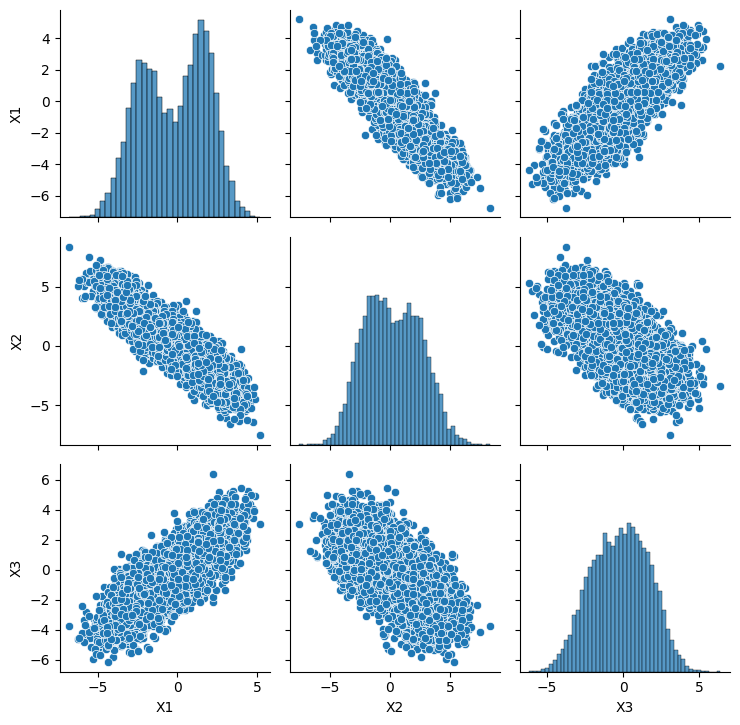

In [ ]:


def generate_VACA_paper_data(n_samples=1000, random_state=None):
    """
    Generate data from the following DAG:
        X1 ~ 0.5 * N(-2, sqrt(1.5)) + 0.5 * N(1.5, 1)
        X2 = -X1 + N(0, 1)
        X3 = X1 + 0.25 * X2 + N(0, 1)

    Parameters:
        n_samples (int): Number of samples to generate.
        random_state (int or None): Random seed for reproducibility.

    Returns:
        pd.DataFrame: DataFrame containing columns ['X1', 'X2', 'X3']
    """
    rng = np.random.default_rng(seed=random_state)

    # Generate X1 from the mixture of Gaussians
    mixture_component = rng.uniform(0, 1, n_samples) < 0.5
    X1 = np.where(
        mixture_component,
        rng.normal(loc=-2, scale=np.sqrt(1.5), size=n_samples),
        rng.normal(loc=1.5, scale=1.0, size=n_samples)
    )

    # Generate X2 and X3 from the structural equations
    noise_X2 = rng.normal(loc=0, scale=1.0, size=n_samples)
    X2 = -X1 + noise_X2

    noise_X3 = rng.normal(loc=0, scale=1.0, size=n_samples)
    X3 = X1 + 0.25 * X2 + noise_X3

    return pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3})

df = generate_VACA_paper_data(n_samples=10_000, random_state=42)
print(df.head())


sns.pairplot(df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()